In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# run_single_scale_detector.py

import cv2
import numpy as np

def run_single_scale_detector(classifier, test_images, scale_factor):
    detections = []
    for image_path in test_images:
        # Load the test image
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image to a fixed size
        resized_image = cv2.resize(gray, (100, 100))

        # Detect faces using the classifier
        faces = classifier.detectMultiScale(resized_image, scaleFactor=scale_factor, minNeighbors=5)

        # Convert the coordinates to original image scale
        for (x, y, w, h) in faces:
            x *= (image.shape[1] / 100)
            y *= (image.shape[0] / 100)
            w *= (image.shape[1] / 100)
            h *= (image.shape[0] / 100)
            detections.append((x, y, w, h))

    return detections


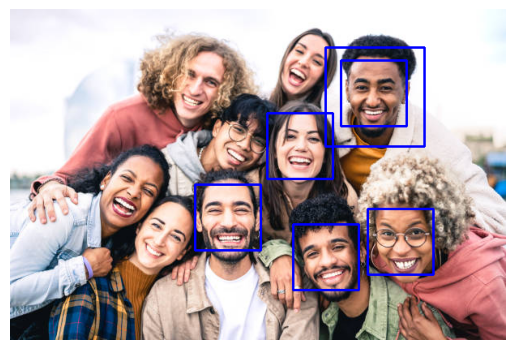

In [ ]:
import cv2
import matplotlib.pyplot as plt

def run_single_scale_detector(classifier, test_images, scale_factor):
    detections = []
    for image_path in test_images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = classifier.detectMultiScale(gray, scaleFactor=scale_factor, minNeighbors=5)
        detections.extend(faces)
    return detections

def main():
    # Load the pre-trained classifier
    classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # Test images
    # test_images = ['/content/face_detection_test.jpg']
    test_images = ['/content/face_detection_test_2.jpg']

    # Run the single scale detector
    scale_factor = 1.5  # Adjust scale factor as needed
    detections = run_single_scale_detector(classifier, test_images, scale_factor)

    # Visualize the detections
    for image_path in test_images:
        image = cv2.imread(image_path)
        for (x, y, w, h) in detections:
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Convert image from BGR to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()



Creating the sliding window, multiscale detector is the most complex part of this project. A single scale detector which does not detect faces at multiple scales in each test image is provided for reference. Such a detector will not work nearly as well (perhaps 0.3 average precision) compared to the full multi-scale detector. With a well trained multi-scale detector with small step size you can expect an average precision above 0.9.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import cv2
from skimage.feature import hog
import numpy as np

def get_positive_features(train_path_pos, feature_params):
    '''
    Load cropped positive trained examples (faces) and convert them to HoG features.
    '''
    template_size = feature_params['template_size']
    hog_cell_size = (feature_params['hog_cell_size'], feature_params['hog_cell_size'])

    hog_features = []

    # Iterate over images in the directory
    for filename in os.listdir(train_path_pos):
        # Read image
        image_path = os.path.join(train_path_pos, filename)
        image = cv2.imread(image_path)
        # Resize image to template size
        image_resized = cv2.resize(image, (template_size, template_size))
        # Convert image to grayscale
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

        features = hog(image_gray, pixels_per_cell=hog_cell_size)
        hog_features.append(features)

    hog_features_np = np.array(hog_features)
    return hog_features_np


In [4]:
import os
import cv2
from skimage.feature import hog
import numpy as np
import random

def get_random_negative_features(non_face_scn_path, feature_params, num_negative_examples):
    '''
    Sample random negative examples from scenes which contain no faces and convert them to HoG features.
    '''
    template_size = feature_params['template_size']
    hog_cell_size = (feature_params['hog_cell_size'], feature_params['hog_cell_size'])

    hog_features = []

    # List all files in the non_face_scn_path directory
    files = os.listdir(non_face_scn_path)
    print(len(files))

    # Sample random negative examples
    sampled_files = random.sample(files, num_negative_examples)
    # Iterate over sampled files
    for filename in sampled_files:
        # Read image
        image_path = os.path.join(non_face_scn_path, filename)
        image = cv2.imread(image_path)
        # Resize image to template size
        image_resized = cv2.resize(image, (template_size, template_size))
        # Convert image to grayscale
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

        features = hog(image_gray, pixels_per_cell=hog_cell_size)
        hog_features.append(features)

    hog_features_np = np.array(hog_features)
    return hog_features_np


In [5]:
from sklearn.svm import LinearSVC

def svm_classify(features_total, labels):
    '''
    Train a linear classifier from the positive and negative examples.
    '''
    classifier = LinearSVC()
    classifier.fit(features_total, labels)
    return classifier


In [6]:
from skimage.transform import pyramid_gaussian
from skimage import data, color, exposure
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.feature import Cascade, hog
from skimage import io
import matplotlib.pyplot as plt

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def run_detector(test_scn_path, model, feature_params):
    # Define parameters
    step_size = 3
    window_size = (36, 36)
    downscale = 1.25

    # Initialize lists to store detected faces
    bboxes = []
    confidences = []
    image_ids = []

    # Iterate through each image in the test set
    for filename in os.listdir(test_scn_path):
        image_path = os.path.join(test_scn_path, filename)
        image = cv2.imread(image_path)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Initialize the pyramid scale
        scale = 1

        # Loop over pyramid levels
        for resized in pyramid_gaussian(image_gray, downscale=downscale):
            # Loop over windows in the pyramid
            for (x, y, window) in sliding_window(resized, step_size=step_size, window_size=window_size):
                # If the window does not meet our desired window size, ignore it
                if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                    continue

                # Extract HOG features from the window
                features = hog(window, pixels_per_cell=(feature_params['hog_cell_size'], feature_params['hog_cell_size']))

                # Make prediction using the SVM classifier
                confidence = model.decision_function(features.reshape(1, -1))

                # If the prediction is positive (face detected)
                if confidence > 0.5:  # Adjust the threshold as needed
                    # Calculate coordinates of the detected face
                    start_x = int(x * (downscale ** scale))
                    start_y = int(y * (downscale ** scale))
                    end_x = int((x + window_size[0]) * (downscale ** scale))
                    end_y = int((y + window_size[1]) * (downscale ** scale))

                    # Add the bounding box coordinates, confidence, and image ID to the lists
                    bboxes.append((start_x, start_y, end_x, end_y))
                    confidences.append(confidence)
                    image_ids.append(filename)

        # Increment the scale for the next iteration
        scale += 1

    bboxes = np.array(bboxes)
    confidences = np.array(confidences)
    image_ids = np.array(image_ids)
    
    return bboxes, confidences, image_ids



In [7]:
def non_max_supr_bbox(bboxes, confidences, img_size, verbose=False):
    """
    FUNC: high confidence detections suppress all overlapping detections
        (including detections at other scales). Detections can partially
        overlap, but the center of one detection can not be within another
        detection.
    ARG:
        - bboxes: (N,4) ndarray; N is the number of non-overlapping detections,
                  and each row is [x_min, y_min, x_max, y_max].
        - confidences: (N,1) ndarray; Confidence of each detection after final
                  cascade node.
        - img_size: (2,) list; [y,x] of the image.
    RET:
        - is_valid_bbox: (N,1) bool ndarray; indicating valid bounding boxes.
    """

    # Truncate bounding boxes to image dimensions
    # print(bboxes,img_size[1])


    # higher confidence detections get priority


    # indicator for whether each bbox will be accepted or suppressed

        # compute overlap as area of intersection / area of union

        # if the less confident detection overlaps too much with the previous detection




    # This statement returns the logical array 'is_valid_bbox' back to the order
    # of the input bboxes and confidences




In [8]:
def VOCap(rec, prec):
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

In [9]:
import numpy as np

# DO NOT MODIFY EVALUATION CODE
def report_accuracy(confidences, label_vector):
    confidences = confidences.ravel()
    label_vector = label_vector.ravel()
    assert confidences.size==label_vector.size, "Size of confidences and label_vector should be the same"
    # compute accuracy
    accuracy = ((label_vector*confidences)>0).sum() / float(confidences.size)
    print("  accuracy: {:.3f}".format(accuracy))

    # compute true positive rate (TP)
    true_positives = np.logical_and((confidences>=0), (label_vector>=0))
    tpr = true_positives.sum() / float(true_positives.size)
    print("  true positive rate: {:.3f}".format(tpr))

    # compute false positive rate (FP)
    false_positives = np.logical_and((confidences>=0), (label_vector<0))
    fpr = false_positives.sum() / float(false_positives.size)
    print("  false positive rate: {:.3f}".format(fpr))

    # compute true negative rate (TN)
    true_negatives = np.logical_and((confidences<0), (label_vector<0))
    tnr = true_negatives.sum() / float(true_negatives.size)
    print("  true negative rate: {:.3f}".format(tnr))

    # compute false negative rate (FN)
    false_negatives = np.logical_and((confidences<0), (label_vector>=0))
    fnr = false_negatives.sum() / float(false_negatives.size)
    print("  false negative rate: {:.3f}".format(fnr))

    return tpr, fpr, tnr, fnr

In [10]:
import numpy as np
from time import time
from matplotlib import pyplot as plt

# DO NOT MODIFY EVALUATION CODE!!!!
def evaluate_detections(bboxes, confidences, image_ids, label_path, fig_path, draw=True):
    """
    FUNC: This function will calculate the result by Pascal VOC Evaluation
    ARG:
        - bboxes: (N, 4) ndarray; N is the number of non-overlapping detections, bboxes[i,:] is
                        [x_min, y_min, x_max, y_max] for detection i.
        - confidences: (N, 1) ndarray; confidences[i] is the real valued confidence
                        of detection i.
        - image_ids: a list;  image_ids[i] is the image file name for detection i.
        - label_path: a string; the path of the file with ground truth bounding boxes for the test set
    """
    # This code is modified from the 2010 Pascal VOC toolkit.
    # http: // pascallin.ecs.soton.ac.uk / challenges / VOC / voc2010 / index.html  # devkit


    f = open(label_path, 'r')
    lines = f.readlines()
    gt_ids = []
    gt_bboxes = np.zeros([len(lines), 4])
    for i in range(len(lines)):
        gt_info = lines[i].rstrip('\r\n').split()
        gt_ids.append(gt_info[0])
        gt_bboxes[i, :] = [float(x) for x in gt_info[1:]]
    f.close()

    gt_isclaimed = np.zeros([len(gt_ids), 1])
    npos = len(gt_ids)  # total number of true positives.

    # sort detections by decreasing confidence
    si = np.squeeze(np.argsort(-confidences, axis=0))
    image_ids = image_ids[si]
    bboxes = bboxes[si]

    # assign detections to ground truth objects
    nd = len(confidences)
    tp = np.zeros([nd, 1])
    fp = np.zeros([nd, 1])
    duplicate_detections = np.zeros([nd, 1])

    t = time()
    for d in range(nd):
        # display progress
        if (time() - t) > 1:
            print ('pr: compute: {}/{}\n'.format(d, nd))
            t = time()

        cur_gt_ids = [i for i, gt_id in enumerate(gt_ids) if image_ids[d] == gt_id]

        bb = bboxes[d, :]
        ovmax = -np.inf

        for j in cur_gt_ids:
            bbgt = gt_bboxes[j, :]
            bi = [max(bb[0], bbgt[0]), max(bb[1], bbgt[1]), min(bb[2], bbgt[2]), min(bb[3], bbgt[3])]
            iw = bi[2] - bi[0] + 1
            ih = bi[3] - bi[1] + 1
            if iw > 0 and ih > 0:
                # compute overlap as area of intersection / area of union
                ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + \
                     (bbgt[2] - bbgt[0] + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                ov = iw * ih / ua
                if ov > ovmax:  # higher overlap than the previous best?
                    ovmax = ov
                    jmax = j

        # assign detection as true positive / don 't care/false positive
        if ovmax >= 0.3:
            if not gt_isclaimed[jmax]:
                tp[d] = 1  # true positive
                gt_isclaimed[jmax] = True
            else:
                fp[d] = 1  # false positive (multiple detection)
                duplicate_detections[d] = 1
        else:
            fp[d] = 1  # false positive

    # compute cumulative precision / recall
    cum_fp = np.cumsum(fp)
    cum_tp = np.cumsum(tp)
    rec = cum_tp / npos
    prec = np.divide(cum_tp, (cum_fp + cum_tp))

    ap = VOCap(rec, prec)

    if draw:
        # plot precision / recall
        fig12 = plt.figure(12)
        line = plt.plot(rec, prec, '-')
        plt.axis([0, 1, 0, 1])
        plt.grid()
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title('Average Precision = {:0.2f}'.format(ap))
        plt.setp(line, 'color', 'blue')

        plt.pause(0.1)  # let's ui rendering catch up
        fig12.savefig('{}/average_precision.png'.format(fig_path))

        plt.figure(13)
        plt.plot(cum_fp, rec, '-')
        plt.axis([0, 300, 0, 1])
        plt.grid()
        plt.xlabel('False positives')
        plt.ylabel('Number of correct detections (recall)')
        plt.title('This plot is meant to match Figure 6 in Viola Jones')

    # # Re-sort return variables so that they are in the order of the input bboxes
    reverse_map = np.zeros([nd], dtype=int)
    reverse_map[si] = range(nd)
    tp = tp[reverse_map]
    fp = fp[reverse_map]
    duplicate_detections = duplicate_detections[reverse_map]

    return gt_ids, gt_bboxes, gt_isclaimed, tp, fp, duplicate_detections

In [11]:
import numpy as np
import os
from skimage.io import imread
from matplotlib import pyplot as plt


def visualize_detections_by_image(bboxes, confidences, image_ids, tp, fp, test_scn_path, label_path, fig_path):
    """
    FUNC: This function will calculate the result by Pascal VOC Evaluation
    ARG:
        - bboxes: (N, 4) ndarray; N is the number of non-overlapping detections, bboxes[i, :] is
                        [x_min, y_min, x_max, y_max] for detection i.
        - confidences: (N, 1) ndarray; confidences[i, :] is the real valued confidence
                        of detection i.
        - image_ids: (N, 1) ndarray;  image_ids[i, :] is the image file name for detection i.
        - label_path: a string; the path of the file with ground truth bounding boxes for the test set
    """

    # This code is modified from the 2010 Pascal VOC toolkit.
    # http: // pascallin.ecs.soton.ac.uk / challenges / VOC / voc2010 / index.html  # devkit
    # This function visualizes all detections in each test image

    f = open(label_path, 'r')
    lines = f.readlines()
    gt_ids = []
    gt_bboxes = np.zeros([len(lines), 4])
    for i in range(len(lines)):
        gt_info = lines[i].rstrip('\r\n').split()
        gt_ids.append(gt_info[0])
        gt_bboxes[i, :] = [float(x) for x in gt_info[1:]]
    f.close()

    gt_file_list = np.unique(gt_ids)
    test_image_list = np.unique(image_ids)

    num_test_images = len(gt_file_list)

    for cur_image_id in test_image_list:

        cur_test_image = imread(os.path.join(test_scn_path, cur_image_id))
        cur_test_image = np.tile(np.expand_dims(cur_test_image, 2), [1, 1, 3])
        cur_gt_detections = [ids for ids, gt_id in enumerate(gt_ids) if cur_image_id == gt_id]
        cur_gt_bboxes = gt_bboxes[cur_gt_detections, :]

        cur_detections = [idx for idx, image_id in enumerate(image_ids) if cur_image_id == image_id[0]]
        cur_bboxes = bboxes[cur_detections, :]
        cur_confidences = confidences[cur_detections]
        cur_tp = tp[cur_detections]
        cur_fp = fp[cur_detections]

        fig15 = plt.figure(15)
        plt.imshow(cur_test_image)

        num_detections = len(cur_detections)
        x_pos = [0, 2, 2, 0, 0]
        y_pos = [1, 1, 3, 3, 1]

        for j in range(num_detections):
            bb = cur_bboxes[j, :]
            if cur_tp[j]:  # this was a correct detection
                plt.plot(bb[x_pos], bb[y_pos], color='g', linewidth=2, linestyle=':')
            elif cur_fp[j]:
                plt.plot(bb[x_pos], bb[y_pos], color='r', linewidth=2)
            else:
                ValueError('a detection was neither a true positive or a false positive')

        num_gt_bboxes = len(cur_gt_bboxes)

        for j in range(num_gt_bboxes):
            bbgt = cur_gt_bboxes[j, :]
            plt.plot(bbgt[x_pos], bbgt[y_pos], color='y', linewidth=2, linestyle='--')

        plt.axis('image')
        plt.axis('off')
        plt.title('image: \"{}\" (green=true pos, red=false pos, yellow=ground truth), {}/{} found'.format(cur_image_id, int(np.sum(cur_tp)), len(cur_gt_bboxes), 'interpreter', 'none'))


        # plt.setp(line, 'color', 'blue')

        plt.pause(0.1)  # let's ui rendering catch up
        fig15.savefig('{}/detections_{}'.format(fig_path, cur_image_id))

        #raw_input('press any key to continue with next image\n')

In [12]:
# Sliding window face detection with linear SVM
import numpy as np
import os
import pdb
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage import draw, exposure


def main():
    # root directory of all data
    data_path = 'data/'

    # directory of positive training examples. 36x36 head crops
    train_path_pos = os.path.join(data_path, 'caltech_faces/Caltech_CropFaces')

    print(train_path_pos)
    # we can mine random or hard negatives from here
    non_face_scn_path = os.path.join(data_path, 'train_non_face_scenes')

    # CMU+MIT test scenes
    test_scn_path = os.path.join(data_path, 'test_scenes/test_jpg')

    # the ground truth face locations in the test set
    label_path = os.path.join(data_path, 'test_scenes/ground_truth_bboxes.txt')

    # directory for saving figure
    fig_path = 'visualizations'
    if not os.path.exists(fig_path):
        os.mkdir(fig_path)

    # The faces are 36x36 pixels, which works fine as a template size. You could
    # add other fields to this struct if you want to modify HoG default
    # parameters such as the number of orientations, but that does not help
    # performance in our limited test.
    feature_params = {'template_size': 36,
                      'hog_cell_size': 6}

    ## Step 1. Load positive training crops and random negative examples
    # YOU CODE 'get_positive_features' and 'get_random_negative_features'
    features_pos = get_positive_features(train_path_pos, feature_params)


    # higher will work strictly better, but your should start with 10000
    num_negative_examples = 100
    features_neg = get_random_negative_features(non_face_scn_path, feature_params, num_negative_examples)

    ## Step 2. Train classifier
    features_total = np.concatenate([features_pos,features_neg], axis=0)
    labels = np.concatenate([np.ones((features_pos.shape[0], 1)), -np.ones((features_neg.shape[0], 1))],
                            axis=0)

    model = svm_classify(features_total, labels)

    ## Step 3. Examine learned classifier
    # You don't need to modify anything in this section. The section first
    # evaluates _training_ error, which isn't ultimately what we care about,
    # but it is a good sanity check. Your training error should be very low.
    print('Initial classifier performance on train data:')
    confidences = model.decision_function(features_total)
    label_vector = labels
    tp_rate, fp_rate, tn_rate, fn_rate = report_accuracy(confidences, label_vector)


    # Visualize how well separated the positive and negative examples are at
    # training time. Sometimes this can identify odd biases in your training
    # data, especially if you're trying hard negative mining. This
    # visualization won't be very meaningful with the placeholder starter code.
    non_face_confs = confidences[label_vector.ravel()<0]
    face_confs = confidences[label_vector.ravel()>0]
    fig2 = plt.figure(2)
    plt.plot(np.arange(non_face_confs.size), np.sort(non_face_confs), color='g')
    plt.plot(np.arange(face_confs.size), np.sort(face_confs), color='r')
    plt.plot([0, non_face_confs.size], [0,0], color='b')


    ## Step 4. (optional) Mine hard negatives
    # Mining hard negatives is extra credit. You can get very good performance
    # by using random negatives, so hard negative mining is somewhat
    # unnecessary for face detection. If you implement hard negative mining,
    # you probably want to modify 'run_detector', run the detector on the
    # images in 'non_face_scn_path', and keep all of the features above some
    # confidence level.

    # hard negative mining

    # hard positive mining

    # training with hard examples

    # estimate again after hard example mining

    # visualize

    ## Step 5. Run detector on test set.
    # YOU CODE 'run_detector'. Make sure the outputs are properly structured!
    # They will be interpreted in Step 6 to evaluate and visualize your
    # results. See run_detector.m for more details.
    bboxes, confidences, image_ids = run_detector(test_scn_path, model, feature_params)

    # run_detector will have (at least) two parameters which can heavily
    # influence performance -- how much to rescale each step of your multiscale
    # detector, and the threshold for a detection. If your recall rate is low
    # and your detector still has high precision at its highest recall point,
    # you can improve your average precision by reducing the threshold for a
    # positive detection.


    ## Step 6. Evaluate and Visualize detections
    # These functions require ground truth annotations, and thus can only be
    # run on the CMU+MIT face test set. Use visualize_detectoins_by_image_no_gt
    # for testing on extra images (it is commented out below).

    # Don't modify anything in 'evaluate_detections'
    gt_ids, gt_bboxes, gt_isclaimed, tp, fp, duplicate_detections = \
        evaluate_detections(bboxes, confidences, image_ids, label_path, fig_path)

    visualize_detections_by_image(bboxes, confidences, image_ids, tp, fp, test_scn_path, label_path, fig_path)

    # performance to aim for
    # random (stater code) 0.001 AP
    # single scale ~ 0.2 to 0.4 AP
    # multiscale, 6 pixel step ~ 0.83 AP
    # multiscale, 4 pixel step ~ 0.89 AP
    # multiscale, 3 pixel step ~ 0.92 AP

if __name__=="__main__":
    main()

data/caltech_faces/Caltech_CropFaces
274


d:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Initial classifier performance on train data:
  accuracy: 1.000
  true positive rate: 0.985
  false positive rate: 0.000
  true negative rate: 0.015
  false negative rate: 0.000
